In [1]:
# --- Step 1: Load & light cleaning ---

import pandas as pd
import numpy as np

# for reproducibility of any random ops later (e.g., train/test split)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load CSV
df = pd.read_excel("../data/regression_data.xls")

# Create a new column for the age of the house when it was sold
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["sale_year"] = df["date"].dt.year
df["age_on_sale"] = df["sale_year"] - df["yr_built"]

# Create a simple renovation flag from yr_renovated, then drop the original
df["renovated"] = (df["yr_renovated"] > 0).astype(int)
df = df.drop(columns=["yr_renovated"], errors="ignore")

# Drop columns we won't model directly
#    - id: identifier (no predictive signal)
#    - date: string/timestamp not directly useful here
#    - lat/long: geospatial (skipping to keep the project simple)
#    - sqft_living15/sqft_lot15: newer-year variants (we'll keep the main ones)
#    - yr_built/sale_year: redundant with age_on_sale
cols_to_drop = ["id", "date", "lat", "long", "sqft_living15", "sqft_lot15", "yr_built", "sale_year"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Quick peek
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,price,age_on_sale,renovated
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,98178,221900,59,0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,98125,538000,63,1
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,98028,180000,82,0
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,98136,604000,49,0
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,98074,510000,28,0


In [2]:
df.shape

(21597, 15)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21597 non-null  int64  
 1   bathrooms      21597 non-null  float64
 2   sqft_living    21597 non-null  int64  
 3   sqft_lot       21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   waterfront     21597 non-null  int64  
 6   view           21597 non-null  int64  
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  int64  
 11  zipcode        21597 non-null  int64  
 12  price          21597 non-null  int64  
 13  age_on_sale    21597 non-null  int64  
 14  renovated      21597 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 2.5 MB


In [4]:
df["price"].mean()

np.float64(540296.5735055795)

In [5]:
# --- Step 2: Separate target, define preprocessing ---

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Target and features
y = df["price"]
X = df.drop(columns=["price"])

# Categorical (discrete ratings/flags we want to one-hot encode)
categorical_cols = ["waterfront", "view", "condition", "grade", "renovated", "zipcode"]

# Numeric: everything else that remains (bedrooms, bathrooms, sqft_*, floors, yr_built, zipcode, etc.)
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# Numeric preprocessing: impute + scale (important for KNN/Ridge/Lasso)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing: impute + one-hot encode (ignore unseen categories safely)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine both into a single transformer used by every model
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

In [6]:
# --- Step 3: Train/Test split & cross-validation setup ---

from sklearn.model_selection import train_test_split, KFold, cross_val_score

# 1. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 2. Cross-validation setup
#    - 3 folds: the training data is split into 3 parts, each used once as a validation set
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
CV_NJOBS = -1 # use all available cores
SCORING = "neg_root_mean_squared_error" # we want to minimize the error

Train shape: (17277, 14) Test shape: (4320, 14)


In [7]:
# --- Step 4: Train Multiple Models & Compare Them Fairly ---

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Dictionary of models
models = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(alpha=5.0),       # alpha controls regularization strength
    "LassoRegression": Lasso(alpha=1.0, max_iter=10000, tol=0.01),       # alpha controls regularization strength
    "KNN": KNeighborsRegressor(n_neighbors=10),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=15, min_samples_leaf=5),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_leaf=2, n_jobs=-1, random_state=RANDOM_STATE)
}

# Store results
results = []
for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=cv,
        scoring=SCORING,        # neg_root_mean_squared_error
        n_jobs=CV_NJOBS,
        error_score="raise"     # or "nan" to keep going on rare failures
    )
    rmse = -scores
    results.append({"Model": name, "Mean RMSE": rmse.mean(), "Std RMSE": rmse.std()})

results_df = (
    pd.DataFrame(results)
      .sort_values("Mean RMSE")
      .assign(**{
          "Mean RMSE": lambda d: d["Mean RMSE"].round(0),
          "Std RMSE":  lambda d: d["Std RMSE"].round(0),
      })
      .reset_index(drop=True)
)

results_df

,Model,Mean RMSE,Std RMSE
0,RidgeRegression,151063.0,7526.0
1,LassoRegression,151572.0,3221.0
2,LinearRegression,151595.0,3205.0
3,RandomForest,166823.0,7043.0
4,KNN,192584.0,12196.0
5,DecisionTree,209486.0,10155.0


Test RMSE: 156,480
Test MAE : 89,632
Test R^2 : 0.812

Top 12 features by |coefficient| (standardized scale):


,feature,coef,abs_coef,type
0,grade_13,1.222373e+06,1.222373e+06,categorical(OHE)
1,zipcode_98039,9.629323e+05,9.629323e+05,categorical(OHE)
2,zipcode_98004,5.279250e+05,5.279250e+05,categorical(OHE)
3,grade_12,4.606285e+05,4.606285e+05,categorical(OHE)
4,zipcode_98112,4.480432e+05,4.480432e+05,categorical(OHE)
5,grade_6,-3.147076e+05,3.147076e+05,categorical(OHE)
6,zipcode_98040,3.114373e+05,3.114373e+05,categorical(OHE)
7,grade_7,-3.100548e+05,3.100548e+05,categorical(OHE)
8,zipcode_98109,3.030821e+05,3.030821e+05,categorical(OHE)
9,grade_5,-2.970630e+05,2.970630e+05,categorical(OHE)


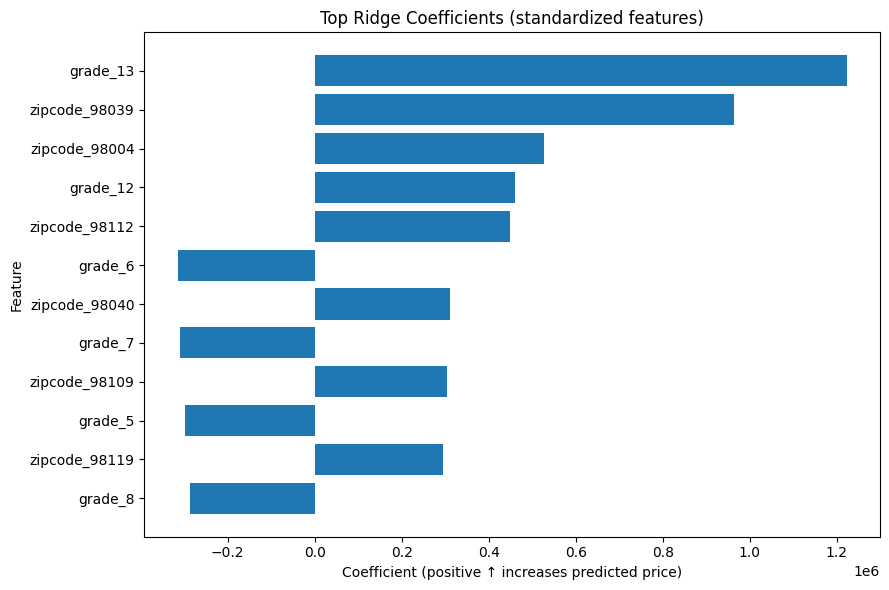

In [8]:
# --- Step 5: Fit the best model (Ridge) + Test metrics + Coefficient "importances" ---

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Refit Ridge on the full training data (same alpha as CV)
best_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=5.0))
])
best_model.fit(X_train, y_train)

# 2) Test set evaluation (fresh, never seen during training/CV)
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:,.0f}")
print(f"Test MAE : {mae:,.0f}")
print(f"Test R^2 : {r2:.3f}")

# 3) Extract feature names after preprocessing
#    - numeric names are unchanged
#    - categorical names come from OneHotEncoder
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, cat_feature_names])

# 4) Ridge coefficients (on standardized features)
coefs = best_model.named_steps["model"].coef_

coef_df = (
    pd.DataFrame({
        "feature": all_feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "type": ["numeric"]*len(numeric_cols) + ["categorical(OHE)"]*len(cat_feature_names)
    })
    .sort_values("abs_coef", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 12 features by |coefficient| (standardized scale):")
display(coef_df.head(12))

# 5) Quick visualization of the most influential features
topN = 12
plt.figure(figsize=(9,6))
plt.barh(coef_df["feature"].head(topN)[::-1], coef_df["coef"].head(topN)[::-1])
plt.title("Top Ridge Coefficients (standardized features)")
plt.xlabel("Coefficient (positive ↑ increases predicted price)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


=== waterfront ===


,count,avg_price,pct_high_value
waterfront,,,
1,163,1662524.0,82.2
0,21434,531762.0,24.2



=== view ===


,count,avg_price,pct_high_value
view,,,
4,319,1464363.0,87.5
3,510,972468.0,66.1
1,332,812519.0,56.0
2,961,792856.0,53.5
0,19475,496740.0,20.6



=== condition ===


,count,avg_price,pct_high_value
condition,,,
5,1701,612578.0,34.2
3,14020,542173.0,24.4
4,5677,521374.0,23.1
1,29,341067.0,6.9
2,170,328179.0,4.7



=== grade ===


,count,avg_price,pct_high_value
grade,,,
12,89,2202528.0,100.0
13,13,3710769.0,100.0
11,399,1497792.0,98.2
10,1134,1072347.0,89.9
9,2615,773738.0,62.6
8,6065,542987.0,24.0
7,8974,402595.0,7.6
5,242,248524.0,1.7
6,2038,301917.0,1.6



=== bedrooms ===


,count,avg_price,pct_high_value
bedrooms,,,
10,3,820000.0,100.0
9,6,894000.0,66.7
8,13,1105077.0,61.5
7,38,951448.0,52.6
6,272,825854.0,50.7
5,1601,786874.0,47.0
4,6882,635565.0,37.2
3,9824,466277.0,16.3
2,2760,401388.0,8.6



=== bathrooms ===


,count,avg_price,pct_high_value
bathrooms,,,
6.75,2,2735000.0,100.0
8.00,2,4990000.0,100.0
7.75,1,6890000.0,100.0
6.50,2,1710000.0,100.0
5.50,10,2522500.0,100.0
6.00,6,2948333.0,100.0
6.25,2,3095000.0,100.0
4.25,79,1526653.0,93.7
4.75,23,2022300.0,91.3



=== floors ===


,count,avg_price,pct_high_value
floors,,,
2.5,161,1061021.0,62.1
2.0,8235,649186.0,37.2
1.5,1910,559045.0,30.4
3.0,611,583434.0,23.2
3.5,7,910214.0,14.3
1.0,10673,442358.0,13.4



=== renovated ===


,count,avg_price,pct_high_value
renovated,,,
1,914,760629.0,46.3
0,20683,530560.0,23.7


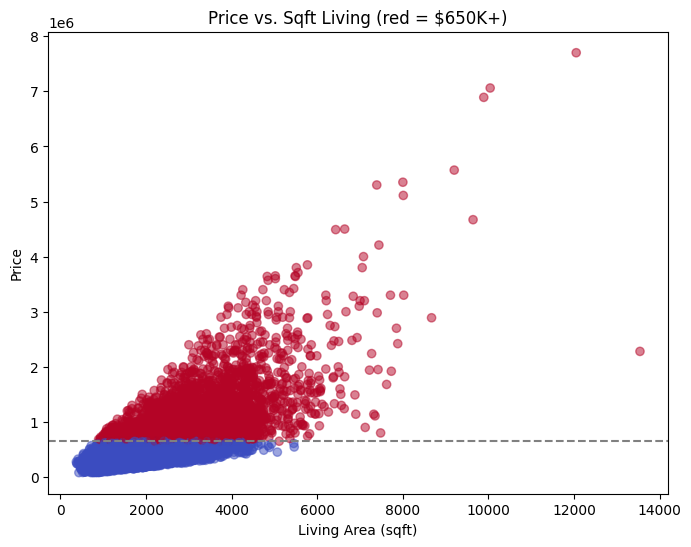

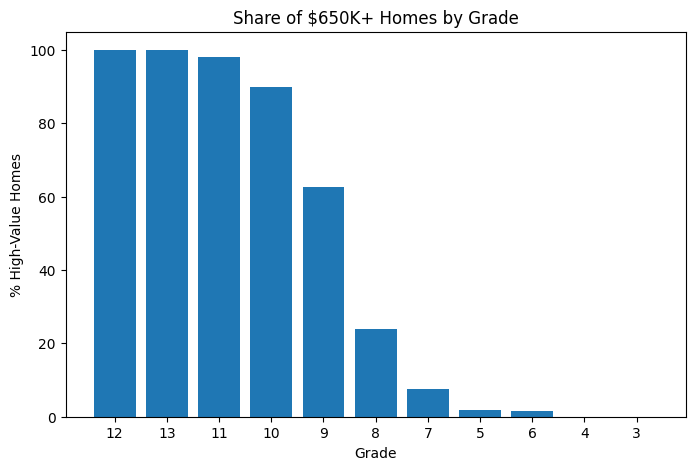

In [9]:
# --- Step 6: Business Question: Which homes are $650K+? ---

# 1) Add binary target for business insight
df["high_value"] = (df["price"] >= 650000).astype(int)

# 2) Helper: summarize a column vs. high-value share
def summarize_high_value(col):
    return (
        df.groupby(col)
          .agg(
              count=("price", "size"),
              avg_price=("price", "mean"),
              pct_high_value=("high_value", "mean")
          )
          .assign(
              avg_price=lambda d: d["avg_price"].round(0),
              pct_high_value=lambda d: (d["pct_high_value"] * 100).round(1)
          )
          .sort_values("pct_high_value", ascending=False)
    )

# 3) Explore key categorical/discrete columns
cols_to_check = ["waterfront", "view", "condition", "grade", "bedrooms", "bathrooms", "floors", "renovated"]

for col in cols_to_check:
    if col in df.columns:
        print(f"\n=== {col} ===")
        display(summarize_high_value(col).head(10))  # show top categories

# 4) Example scatter plot: price vs sqft_living, highlighting $650K+
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df["sqft_living"], df["price"], c=df["high_value"], cmap="coolwarm", alpha=0.5)
plt.axhline(650000, color="gray", linestyle="--")
plt.xlabel("Living Area (sqft)")
plt.ylabel("Price")
plt.title("Price vs. Sqft Living (red = $650K+)")
plt.show()

# 5) Example bar plot: share of high-value homes by grade
summary = summarize_high_value("grade").reset_index()
plt.figure(figsize=(8,5))
plt.bar(summary["grade"].astype(str), summary["pct_high_value"])
plt.ylabel("% High-Value Homes")
plt.xlabel("Grade")
plt.title("Share of $650K+ Homes by Grade")
plt.show()

In [10]:
# Step 7: Export cleaned data

# Make a copy to avoid accidental modifications
df_clean = df.copy()

# Ensure it's clean: no missing target, all relevant columns present
df_clean = df_clean.dropna(subset=["price"])

# Save to CSV
df_clean.to_csv("../data/cleaned_data.csv", index=False)